In [1]:
!pip install pandas scikit-learn scipy seaborn

In [2]:
from include.graficos import *
from include.utils import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

**1. Definição do Problema de Negócios**

**Contexto do Problema:**

O contexto do problema é a construção de um modelo preditivo para prever os custos médicos individuais cobrados pelo seguro de saúde.
Isso envolve analisar um conjunto de dados que contém informações sobre características individuais, como idade, gênero, IMC (índice de massa corporal), número de filhos, fumante ou não, região, entre outros, e os custos médicos correspondentes.

**Objetivos da Análise:**

- Considerar na escolha do modelo aquele que entregar a melhor acurácia.
- Desenvolver um modelo preditivo que possa fazer previsões confiáveis dos custos médicos individuais com base nas características fornecidas.
- Avaliar a importância das diferentes características no modelo de previsão de custos médicos.
- Identificar padrões e relacionamentos nos dados que possam ajudar a melhorar a precisão das previsões.
- Fornecer insights para ajudar a entender os principais fatores que influenciam os custos médicos individuais.

**Perguntas de Negócios:**

- Quais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?
- Existe alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?
- O número de filhos influencia significativamente nos custos médicos?
- Há uma diferença significativa nos custos médicos entre fumantes e não fumantes?
- Como o modelo pode ser utilizado para prever e planejar os custos médicos futuros?

**Benefícios Esperados:**

- Melhor compreensão dos fatores que contribuem para os custos médicos individuais.
- Desenvolvimento de um modelo preditivo preciso que possa ser usado para prever custos médicos futuros com base em diferentes características individuais.
- Melhoria na precificação do seguro de saúde, permitindo uma cobrança mais precisa e justa dos prêmios.
- Potencial economia de custos para seguradoras e segurados, evitando subestimação ou superestimação dos custos médicos.

**Descrição dos dados disponíveis**
    
Os dados disponíveis consistem em um conjunto de informações sobre segurados de um plano de saúde. Cada entrada no conjunto de dados contém as seguintes características:

- **Idade (int):** A idade do segurado.
- **Gênero (string):** O gênero do segurado (masculino ou feminino).
- **IMC (float):** O índice de massa corporal do segurado.
- **Número de Filhos (int):** O número de filhos do segurado.
- **Fumante (string):** Indicação se o segurado é fumante ou não.
- **Região (string):** A região geográfica onde o segurado reside.
- **Encargos (float):** Os custos médicos individuais cobrados pelo seguro de saúde.

Durante o processamento, os dados são salvos em 7 planilhas (pasta planilhas):
- **1_dados_sinteticos.csv:** Esta planilha é gerada com dados embaralhados, contendo dados nan em colunas distintas e também de forma aleatória
- **2_dados_processados_treino.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos o conjunto dos treinos
- **3_dados_processados_teste.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos o conjunto dos testes
- **4_dados_processados_treino_target.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos os alvos dos treinos
- **5_dados_processados_teste_target.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos os alvos dos testes
- **6_dados_com_outliers.csv:** Esta planilha demostra os outliers para cada coluna
- **7_dados_futuros.csv:** Esta planilha é gerada para realizar previsões futuras, após escolha do melhor modelo

Esses dados serão utilizados para desenvolver um modelo preditivo para prever os custos médicos individuais com base nas características fornecidas. Para alcançar esse objetivo, a avaliação dos modelos será realizada com base em métricas como R² (coeficiente de determinação), MAE (erro absoluto médio) e MSE (Erro Médio Quadrático) para medir a acurácia dos modelos. A seleção do melhor modelo será feita com base na acurácia média com validação cruzada, e a otimização de hiperparâmetros será direcionada para maximizar a acurácia do modelo selecionado.

**2. Análise dos Dados**

Nesta seção, preparamos o diretório alvo para salvar todas as planilhas deste Tech Challenge.

In [3]:
# Obtém a largura do terminal - uso mais embaixo nos prints
terminal_width = os.get_terminal_size().columns

# Define o caminho do diretório em que deseja salvar o arquivo
output_dir = '../planilhas'

# Verifica se o diretório existe
if not os.path.exists(output_dir):
    # Se o diretório não existe, cria-o
    os.makedirs(output_dir)
else:
    # Limpa todos os arquivos existentes no diretório
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        try:
            # Remove o arquivo
            os.remove(file_path)
            print(f"Arquivo '{filename}' removido com sucesso.")
        except Exception as e:
            print(f"Ocorreu um erro ao tentar remover o arquivo '{filename}': {e}")

Arquivo '1_dados_sinteticos.csv' removido com sucesso.
Arquivo '2_dados_processados_treino.csv' removido com sucesso.
Arquivo '3_dados_processados_teste.csv' removido com sucesso.
Arquivo '4_dados_processados_treino_target.csv' removido com sucesso.
Arquivo '5_dados_processados_teste_target.csv' removido com sucesso.
Arquivo '6_dados_com_outliers.csv' removido com sucesso.
Arquivo '7_dados_futuros.csv' removido com sucesso.


**Sumário dos Dados:**

Nesta seção, apresentamos um resumo dos dados aleatórios gerados para a análise, seguindo as features pedidas no Tech Challenge. Fornecemos uma visualização de todas as colunas do dataset, incluindo uma descrição de suas características. Os principais pontos abordados nesta seção incluem:

- **Colunas e tipos de dados:** Listamos todas as colunas do dataset, juntamente com seus respectivos tipos de dados, para uma compreensão clara da estrutura dos dados.
- **Quantidade de linhas:** Indicamos o número total de linhas presentes no dataset, fornecendo uma ideia do tamanho da amostra.
- **Ausência de dados:** Identificamos a presença de valores ausentes em cada uma das colunas, destacando as features que vão exigir tratamento adicional.
  
Este sumário oferece uma visão geral da composição dos dados e serve como base para análises posteriores.

In [4]:
# Variáveis necessárias para geração da planilha 1_dados_sinteticos.csv
quantidade_linhas = 10000
quantidade_ausencia_dados = 500

# Criando o csv que será usado neste Tech Challenge
dados = obter_csv_dados_aleatorios(quantidade_linhas, quantidade_ausencia_dados)

In [5]:
# Criando uma nova coluna 'Categoria_IMC' depois da coluna 'IMC'
dados.insert(dados.columns.get_loc('IMC') + 1, 'Categoria_IMC', dados['IMC'].apply(categorizar_imc))

# Imprimindo detalhes necessários
print('-' * terminal_width)
print("\nLista de todas colunas:\n\n", list(dados))
print('-' * terminal_width)
print("\nAmostra dos dados:\n\n", dados.head())
print('-' * terminal_width)
print(f"\nQuantidade de linhas: {dados.shape[0]}. Quantidade de colunas: {dados.shape[1]}")
print('-' * terminal_width)
print("\nTipos de dados das colunas:\n\n", dados.dtypes)
print('-' * terminal_width)
print("\nQuantidade de valores ausentes por coluna:\n\n", dados.isnull().sum())

----------------------------------------------------------------------------------------------------------------------------------------------------

Lista de todas colunas:

 ['Idade', 'Gênero', 'IMC', 'Categoria_IMC', 'Filhos', 'Fumante', 'Região', 'Encargos']
----------------------------------------------------------------------------------------------------------------------------------------------------

Amostra dos dados:

    Idade    Gênero    IMC Categoria_IMC  Filhos Fumante    Região  Encargos
0     36  feminino  28.58     Sobrepeso       1     não  nordeste   4085.11
1     36  feminino  19.67   Peso normal       3     sim  sudoeste   5073.88
2     35  feminino  23.27   Peso normal       3     sim  sudoeste   5062.08
3     44  feminino  23.40   Peso normal       1     não  nordeste   4188.74
4     26  feminino  34.95         Obeso       2     não  nordeste   3876.83
--------------------------------------------------------------------------------------------------------------

**Visualização dos Dados:**

Nesta seção, apresentamos gráficos que ajudam a entender a distribuição e padrões nos dados.

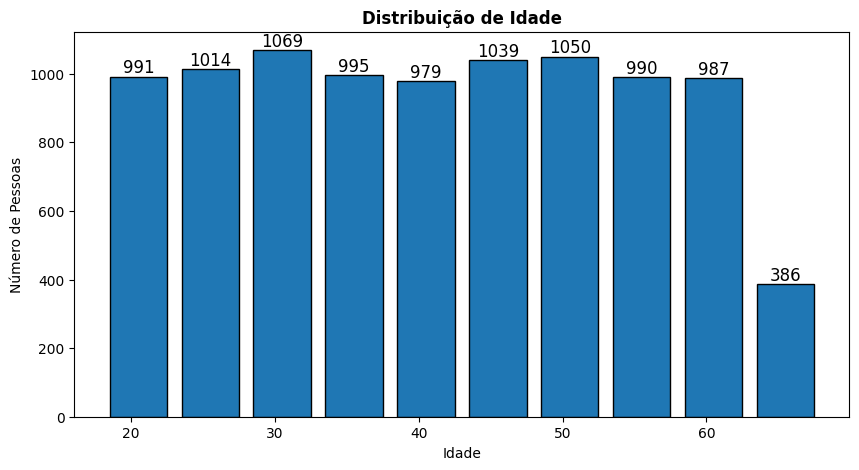

In [6]:
montar_grafico_histograma_idade(dados, 'Distribuição de Idade', 'Idade', 'Número de Pessoas')

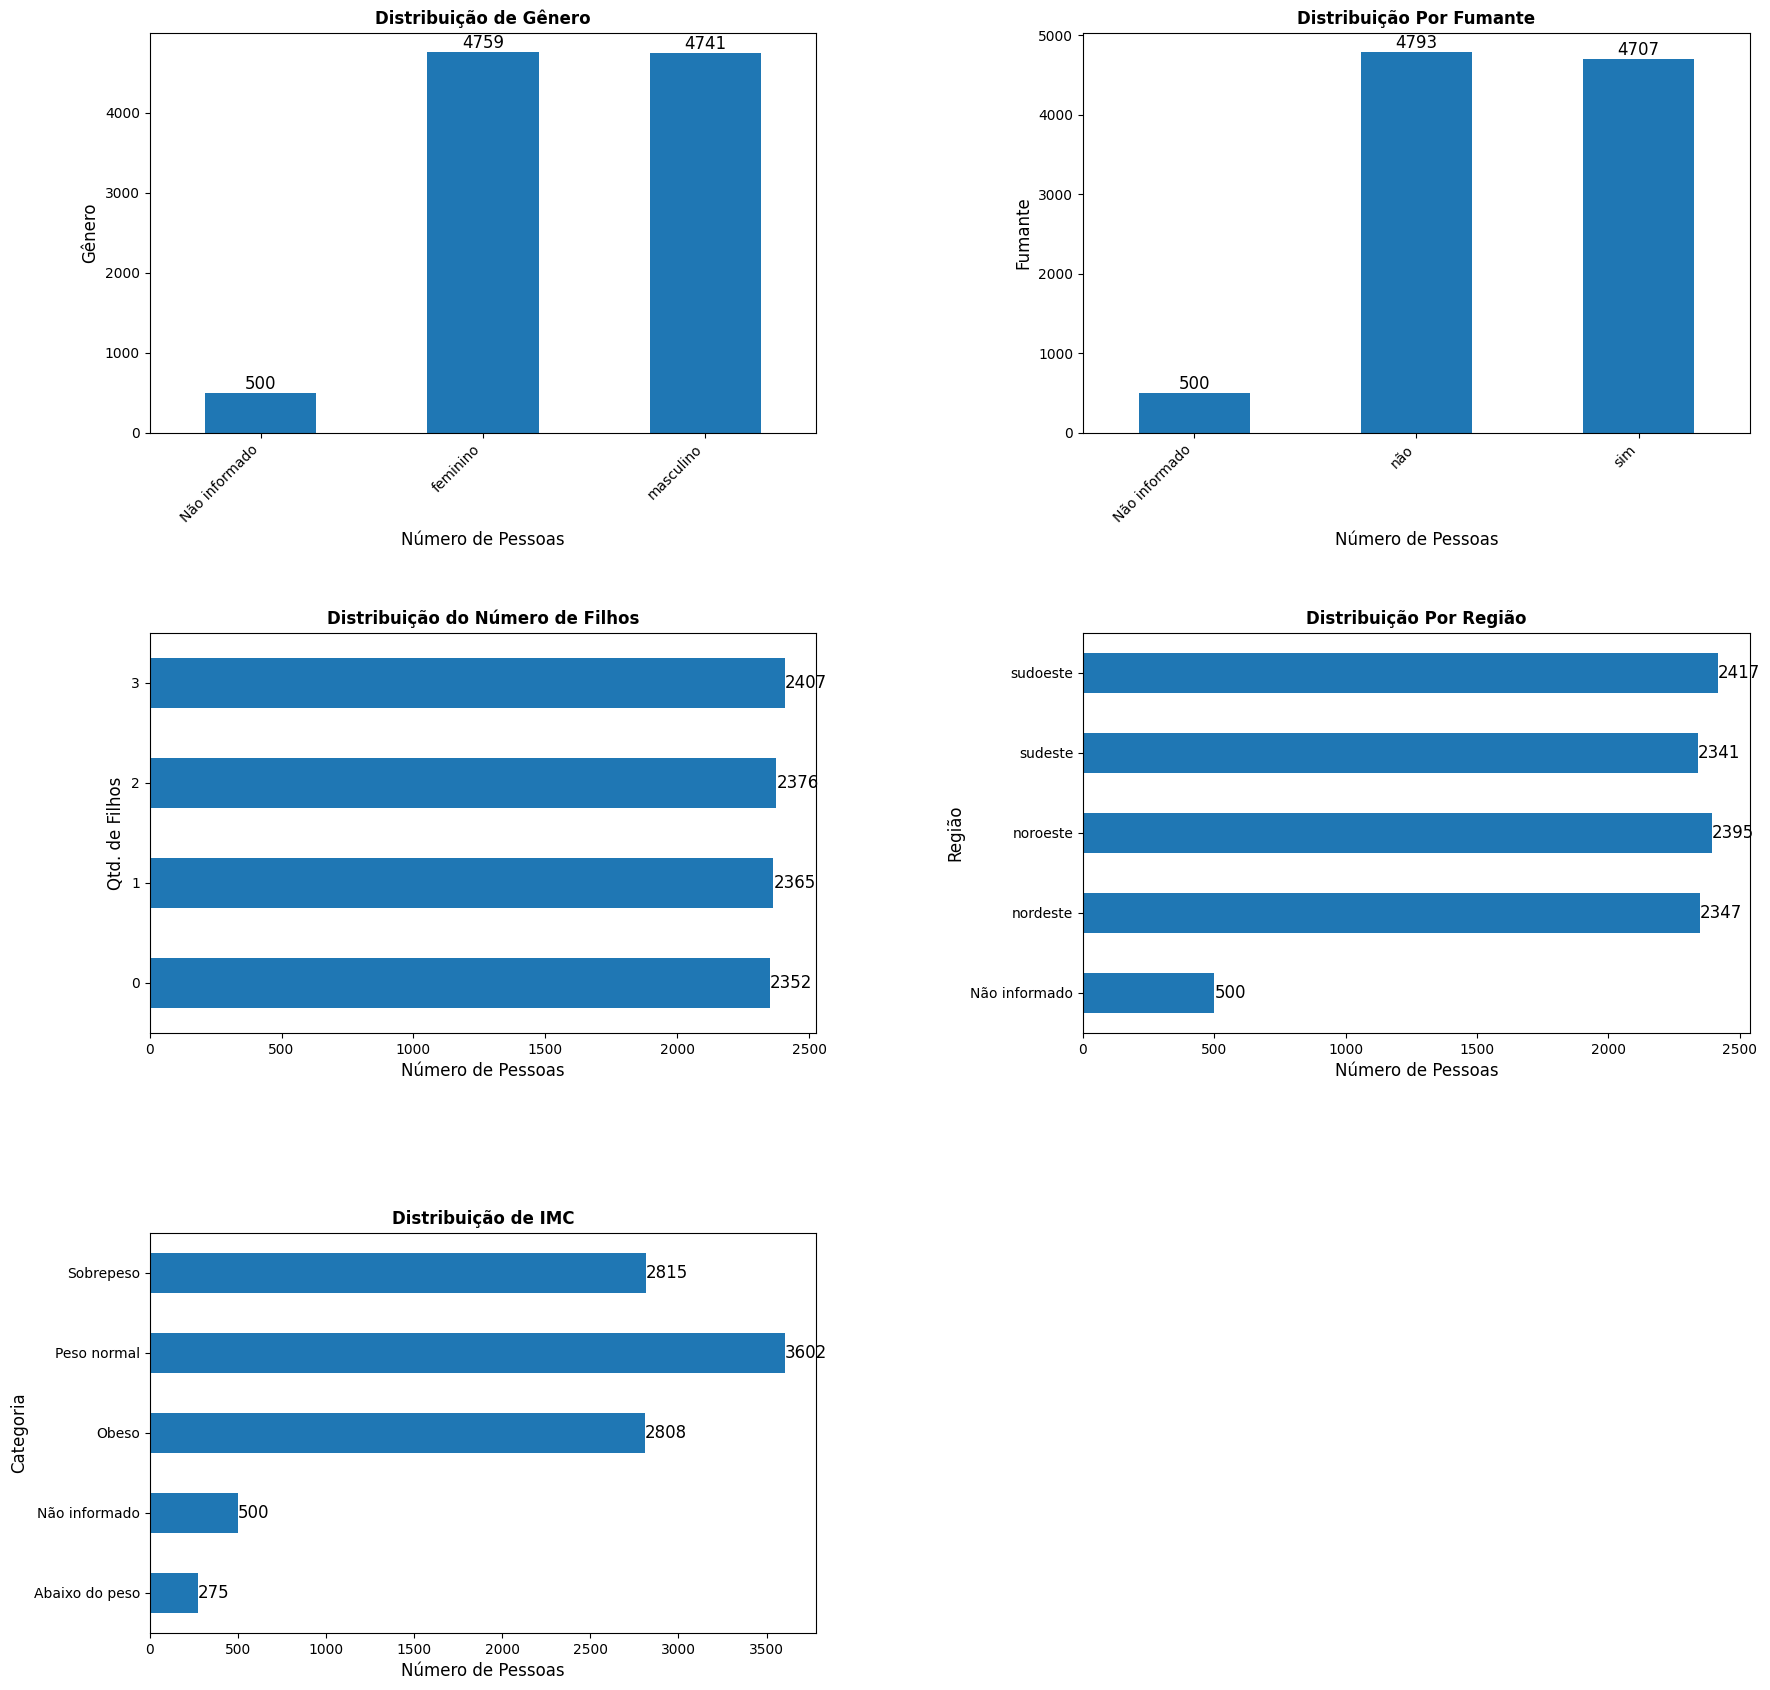

In [7]:
montar_graficos_visualizacao_inicial(dados)

**3. Limpeza de Dados**

Nesta seção, aplicamos a limpeza dos dados originais.
Em seguida, verificamos a quantidade de valores ausentes por coluna, e exibimos o número total de linhas e colunas deste conjunto de dados.

In [8]:
dados_clean = limpar_dados(dados)

print("\nQuantidade de valores ausentes por coluna:\n\n", dados_clean.isnull().sum())
print(f"\nQuantidade de linhas: {dados_clean.shape[0]}. Quantidade de colunas: {dados_clean.shape[1]}")


Quantidade de valores ausentes por coluna:

 Idade            0
Gênero           0
IMC              0
Categoria_IMC    0
Filhos           0
Fumante          0
Região           0
Encargos         0
dtype: int64

Quantidade de linhas: 10000. Quantidade de colunas: 8


**4. Separação dos Dados em Treino e Teste**

Nesta seção, realizamos a separação do dataset em dois subconjuntos: treino. Esta divisão é essencial para garantir uma validação adequada do modelo. Os principais pontos abordados nesta seção incluem:

- **Divisão dos dados:** O dataset é dividido em dois subconjuntos com proporção definida entre os conjuntos de treino (80%) e teste (20%).
- **Gravação da separação dos conjuntos:** Guardamos uma planilha para cada conjunto desta segmentação na pasta planilhas, o que facilitou ainda mais o entedimento de cada etapa realizada.
- **Objetivo da separação:** O conjunto de treino é utilizado para ajustar e treinar o modelo, enquanto o conjunto de teste é reservado para avaliar o desempenho do modelo.
- **Manutenção da representatividade:** Garantimos que a divisão dos dados preserve a distribuição original das características do dataset, permitindo uma avaliação precisa e imparcial do modelo.

In [9]:
# Dividindo os dados em features (X) e target (y)
X = dados_clean.drop(['Encargos','Gênero','Região','Categoria_IMC'], axis=1)  # descartando colunas não necessárias para o teste
colunas_descartadas = dados_clean[['Gênero','Região','Categoria_IMC']]

y = dados_clean['Encargos']

# Codificando variáveis com LabelEncoder
label_encoder = LabelEncoder()
#X['Fumante'] = X['Fumante'].astype(str)  # Converte a coluna para string (após a limpeza os dados ficaram como sim, não e 0
X['Fumante'] = label_encoder.fit_transform(X['Fumante'])

# Substituindo valores 'sim' e 'não' por 1 e 0 (comentando porque o resultado é o mesmo no LabelEncoder
#X['Fumante'] = X['Fumante'].map({'sim': 1, 'não': 0})

print("\nAmostra dos primeiros 20 registros:\n\n", X.head(20))


Amostra dos primeiros 20 registros:

     Idade    IMC  Filhos  Fumante
0      36  28.58       1        1
1      36  19.67       3        2
2      35  23.27       3        2
3      44  23.40       1        1
4      26  34.95       2        1
5      44  18.36       0        2
6      40  33.44       2        1
7      45  32.48       0        1
8      27  21.77       2        2
9      56   0.00       1        1
10     40  26.28       0        1
11      0  24.02       0        2
12     58  26.34       2        1
13     37  33.70       3        2
14      0  24.04       2        2
15     28  25.20       2        1
16     33  31.41       1        1
17     57  25.39       3        1
18     50  22.69       2        1
19     56  29.34       3        1


In [10]:
# Comentado todo bloco abaixo que usava OneHotEncoder, durante o desenvolvimento decidimos outras estratégias (mas mantivemos para estudos futuros)
# Dividir os dados em features (X) e target (y)
#X = dados.drop(['Encargos'], axis=1)  # descartando colunas não necessárias para o teste
#y = dados['Encargos']

# Codificar variáveis categóricas usando one-hot encoding
#colunas_codificadas_via_one_hot = ['Região']
#encoder = OneHotEncoder(drop='first')
#X_encoded = encoder.fit_transform(X[colunas_codificadas_via_one_hot])

# Concatenar features codificadas com as restantes
#X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(colunas_codificadas_via_one_hot), index=X.index)
#X = pd.concat([X.drop(colunas_codificadas_via_one_hot, axis=1), X_encoded], axis=1)

# Codificar variáveis com LabelEncoder
#label_encoder = LabelEncoder()
#X['Gênero'] = label_encoder.fit_transform(X['Gênero'])
#X['Fumante'] = label_encoder.fit_transform(X['Fumante'])

#X['Categoria_IMC'] = label_encoder.fit_transform(X['Categoria_IMC'])

In [11]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inserindo as colunas descartadas em X_train
for coluna in colunas_descartadas.columns:
    X_train.insert(loc=len(X_train.columns), column=coluna, value=colunas_descartadas[coluna])

# Inserindo as colunas descartadas em X_test
for coluna in colunas_descartadas.columns:
    X_test.insert(loc=len(X_test.columns), column=coluna, value=colunas_descartadas[coluna])

# Salvando o conjunto dos treinos
X_train.to_csv("../planilhas/2_dados_processados_treino.csv", index=False, encoding='latin1')

# Salvando o conjunto dos testes
X_test.to_csv("../planilhas/3_dados_processados_teste.csv", index=False, encoding='latin1')

# Salvando o conjunto dos alvos do treino
y_train.to_csv("../planilhas/4_dados_processados_treino_target.csv", index=False, encoding='latin1')

# Salvando o conjunto dos alvos do teste
y_test.to_csv("../planilhas/5_dados_processados_teste_target.csv", index=False, encoding='latin1')

**5. Análise Exploratória de Dados**

**Resumo Estatístico:**

Nesta seção, fornecemos uma visão detalhada das características estatísticas do dataset. Realizamos uma análise geral e específica de algumas features, destacando os principais aspectos estatísticos. Os tópicos abordados incluem:

- **Descrição geral e de algumas features:** Utilizamos estatísticas descritivas para apresentar uma visão geral do dataset, bem como uma análise específica de algumas features selecionadas. As métricas incluem média, mediana, variância, mínimo, máximo e quartis.
- **Detalhes adicionais das features:** Com o auxílio de uma função personalizada, mostramos informações adicionais sobre as features, incluindo o tipo da feature, a faixa de valores, o valor mais frequente e quantas vezes ele ocorre.
- **Mapa de calor (heatmap):** Apresentamos um mapa de calor que ilustra a correlação entre as diferentes features do dataset. Damos especial atenção à correlação entre as features e a variável target, neste caso, Encargos.

Este resumo estatístico oferece uma compreensão mais profunda da estrutura e relações dos dados, auxiliando na identificação de padrões, tendências e potenciais áreas de interesse para análises futuras.

In [12]:
print("\nResumo Estatístico sobre todos os dados:\n\n", dados.describe())
print('-' * terminal_width)
print("\nResumo Estatístico sobre a feature Gênero:\n\n", dados.groupby("Gênero").describe())
print('-' * terminal_width)
print("\nResumo Estatístico sobre a feature Categoria IMC:\n\n", dados.groupby("Categoria_IMC").describe())
print('-' * terminal_width)
print("\nResumo Estatístico sobre a feature Fumante:\n\n", dados.groupby("Fumante").describe())
print('-' * terminal_width)
print("\nResumo Estatístico sobre a feature Região:\n\n", dados.groupby("Região").describe())


Resumo Estatístico sobre todos os dados:

            Idade          IMC    Filhos      Encargos
count     9500.0  9500.000000    9500.0  10000.000000
mean   40.926632    26.485909  1.509263   4486.864973
std    13.478582     4.879054  1.118902   1123.393726
min         18.0    18.010000       0.0    671.570000
25%         29.0    22.310000       1.0   3748.310000
50%         41.0    26.500000       2.0   4526.770000
75%         52.0    30.662500       3.0   5300.622500
max         64.0    35.000000       3.0   7550.000000
----------------------------------------------------------------------------------------------------------------------------------------------------

Resumo Estatístico sobre a feature Gênero:

             Idade                                                         IMC  \
            count       mean        std   min   25%   50%   75%   max   count   
Gênero                                                                          
feminino   4532.0  40.903575  13

In [13]:
# Imprindo dados mais específicos de algumas colunas
dados_especificos_coluna(dados, "Idade")
dados_especificos_coluna(dados, "IMC")
dados_especificos_coluna(dados, "Filhos")
dados_especificos_coluna(dados, "Encargos")


Na coluna Idade (Int64) a faixa dos dados está entre: 18 até 64.
O valor mais frequente na coluna Idade é: 46, que aparece 237 vezes.

Na coluna IMC (float64) a faixa dos dados está entre: 18.01 até 35.0.
O valor mais frequente na coluna IMC é: 33.44, que aparece 15 vezes.

Na coluna Filhos (Int64) a faixa dos dados está entre: 1 até 3.
O valor mais frequente na coluna Filhos é: 3, que aparece 2407 vezes.

Na coluna Encargos (float64) a faixa dos dados está entre: 671.57 até 7550.0.
O valor mais frequente na coluna Encargos é: 3690.77, que aparece 3 vezes.


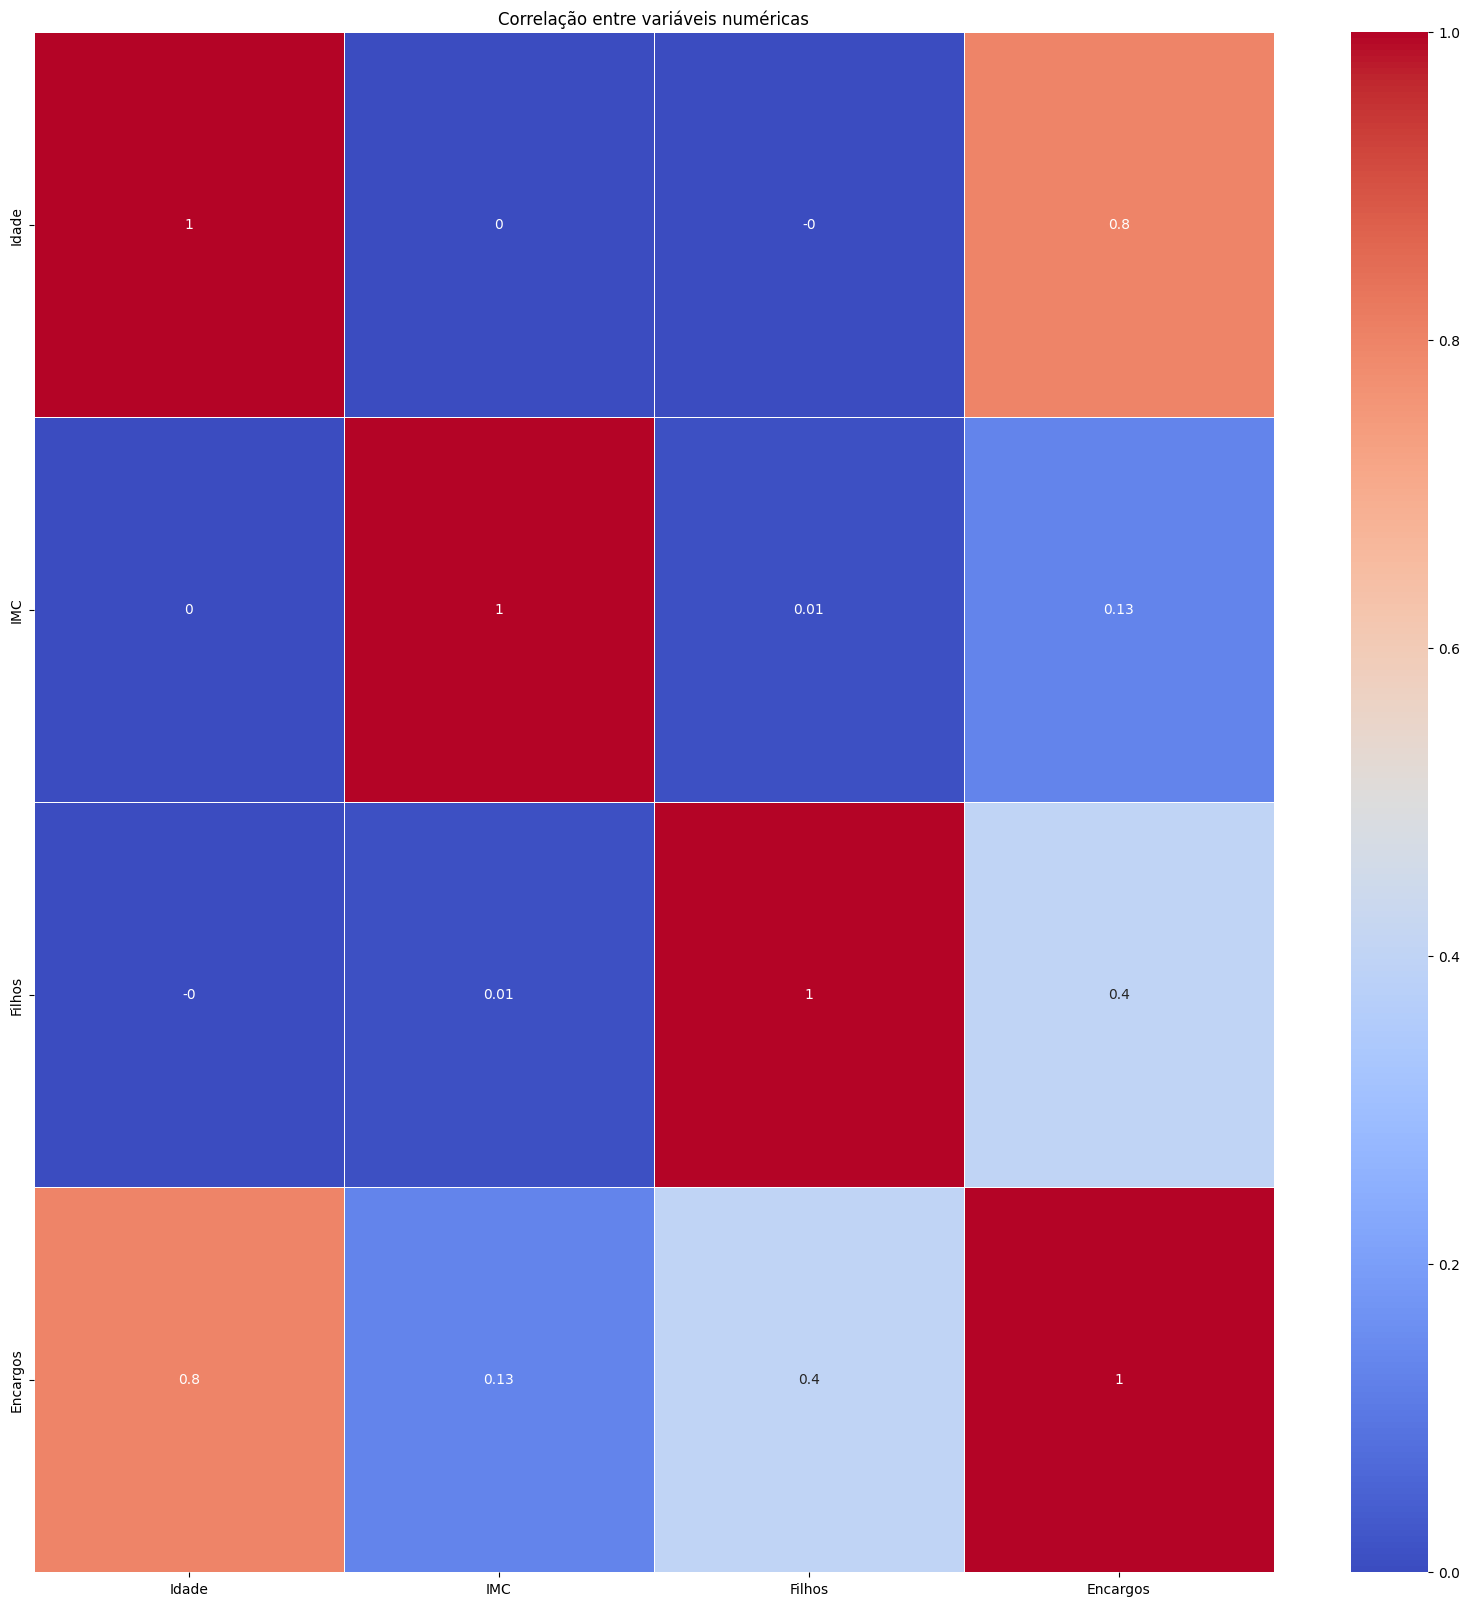

In [14]:
# Seleciona apenas as variáveis numéricas para o cálculo da correlação
numeric_columns = dados.select_dtypes(include='number')

# Calcula a matriz de correlação entre as variáveis numéricas
correlation_matrix_numeric = numeric_columns.corr().round(2)

# Gerando gráfico de mapa de calor para as variáveis numéricas
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data=correlation_matrix_numeric, annot=True, linewidths=.5, ax=ax, cmap="coolwarm")
plt.title("Correlação entre variáveis numéricas")
plt.show()

In [15]:
# Selecionando apenas as variáveis categóricas para o cálculo da correlação ANOVA
categorical_columns = dados.select_dtypes(include='object').columns.tolist()

# Calculando a correlação entre variáveis categóricas usando ANOVA
correlation_anova = pd.DataFrame(index=categorical_columns, columns=numeric_columns.columns)

for cat_col in categorical_columns:
    for num_col in numeric_columns.columns:
        f_stat, p_value = anova_correlation(dados, num_col, cat_col)
        correlation_anova.loc[cat_col, num_col] = p_value.round(2)

# Mostrando a tabela de correlação ANOVA
print("Correlação ANOVA entre variáveis categóricas e numéricas:\n\n", correlation_anova)

# Nota: O valor p pode ser usado para interpretar a significância da correlação entre
# as variáveis categóricas e numéricas. Valores de p baixos indicam maior significância.

Correlação ANOVA entre variáveis categóricas e numéricas:

               Idade  IMC Filhos Encargos
Gênero          NaN  NaN    NaN     0.22
Categoria_IMC   NaN  NaN    NaN      0.0
Fumante         NaN  NaN    NaN      0.0
Região          NaN  NaN    NaN     0.76


**Identificação de Outliers:**

Nesta seção, examinamos o dataset para identificar outliers nas diferentes features, considerando apenas aquelas de natureza numérica, uma vez que o z-score é aplicável somente a esses tipos de dados. Outliers são valores que se desviam significativamente da distribuição geral dos dados, podendo distorcer análises e modelos. Os aspectos destacados incluem:

- **Identificação de outliers nas features:** Calculamos o z-score para cada valor em cada feature, permitindo-nos identificar os valores que estão significativamente desviados da média da distribuição. Esses valores, com um z-score além de um determinado limite (definido como três, neste caso), são marcados como outliers. Marcamos os outliers e alvamos os dados na planilha 6_dados_com_outliers.csv.
- **Visualização com gráfico boxplot:** Utilizamos o gráfico boxplot para visualizar a distribuição das features e destacar os outliers identificados pelo z-score. O boxplot exibe a dispersão dos dados, incluindo quartis, mediana e outliers, oferecendo uma representação visual clara das características dos dados e dos valores extremos.

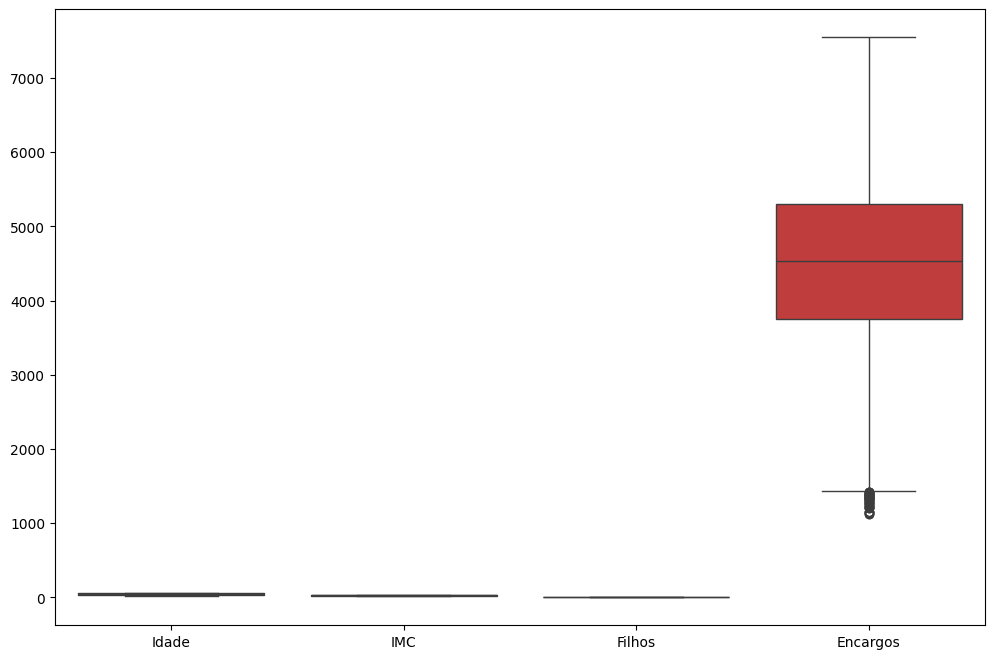

In [16]:
# Calcular o z-score e identificar outliers
for coluna in dados.columns:
    # Só realizar em colunas numéricas
    if dados[coluna].dtype in ['int32', 'int64', 'float64']:        
        # Calculando o z-score para cada valor da coluna
        z_scores = np.abs(stats.zscore(dados[coluna]))
        
        # Limite definido para identificar outliers (pode ser modificado se necessário)
        limite_z = 3
        
        # Marcando os outliers como NaN com base no z-score
        dados['outlier_mask_' + coluna] = (np.abs(z_scores) > limite_z).astype(int)
        dados[coluna] = dados[coluna].mask(dados['outlier_mask_' + coluna] == 1)

# Salvando os dados com os outliers em um arquivo CSV
dados.to_csv("../planilhas/6_dados_com_outliers.csv", index=False, encoding='latin1')

# Remover colunas de máscara de outliers
dados.drop(columns=[col for col in dados.columns if 'outlier_mask_' in col], inplace=True)

# Plotar o boxplot para visualizar os dados
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=dados, ax=ax)

# Mostrar o gráfico
plt.show()

**Visualizações Gráficas:**

Nesta seção, apresentamos visualizações gráficas que ajudam a compreender a distribuição e os relacionamentos entre as features mais correlacionadas (conforme visto na seção Resumo Estatístico) com a variável target Encargos.

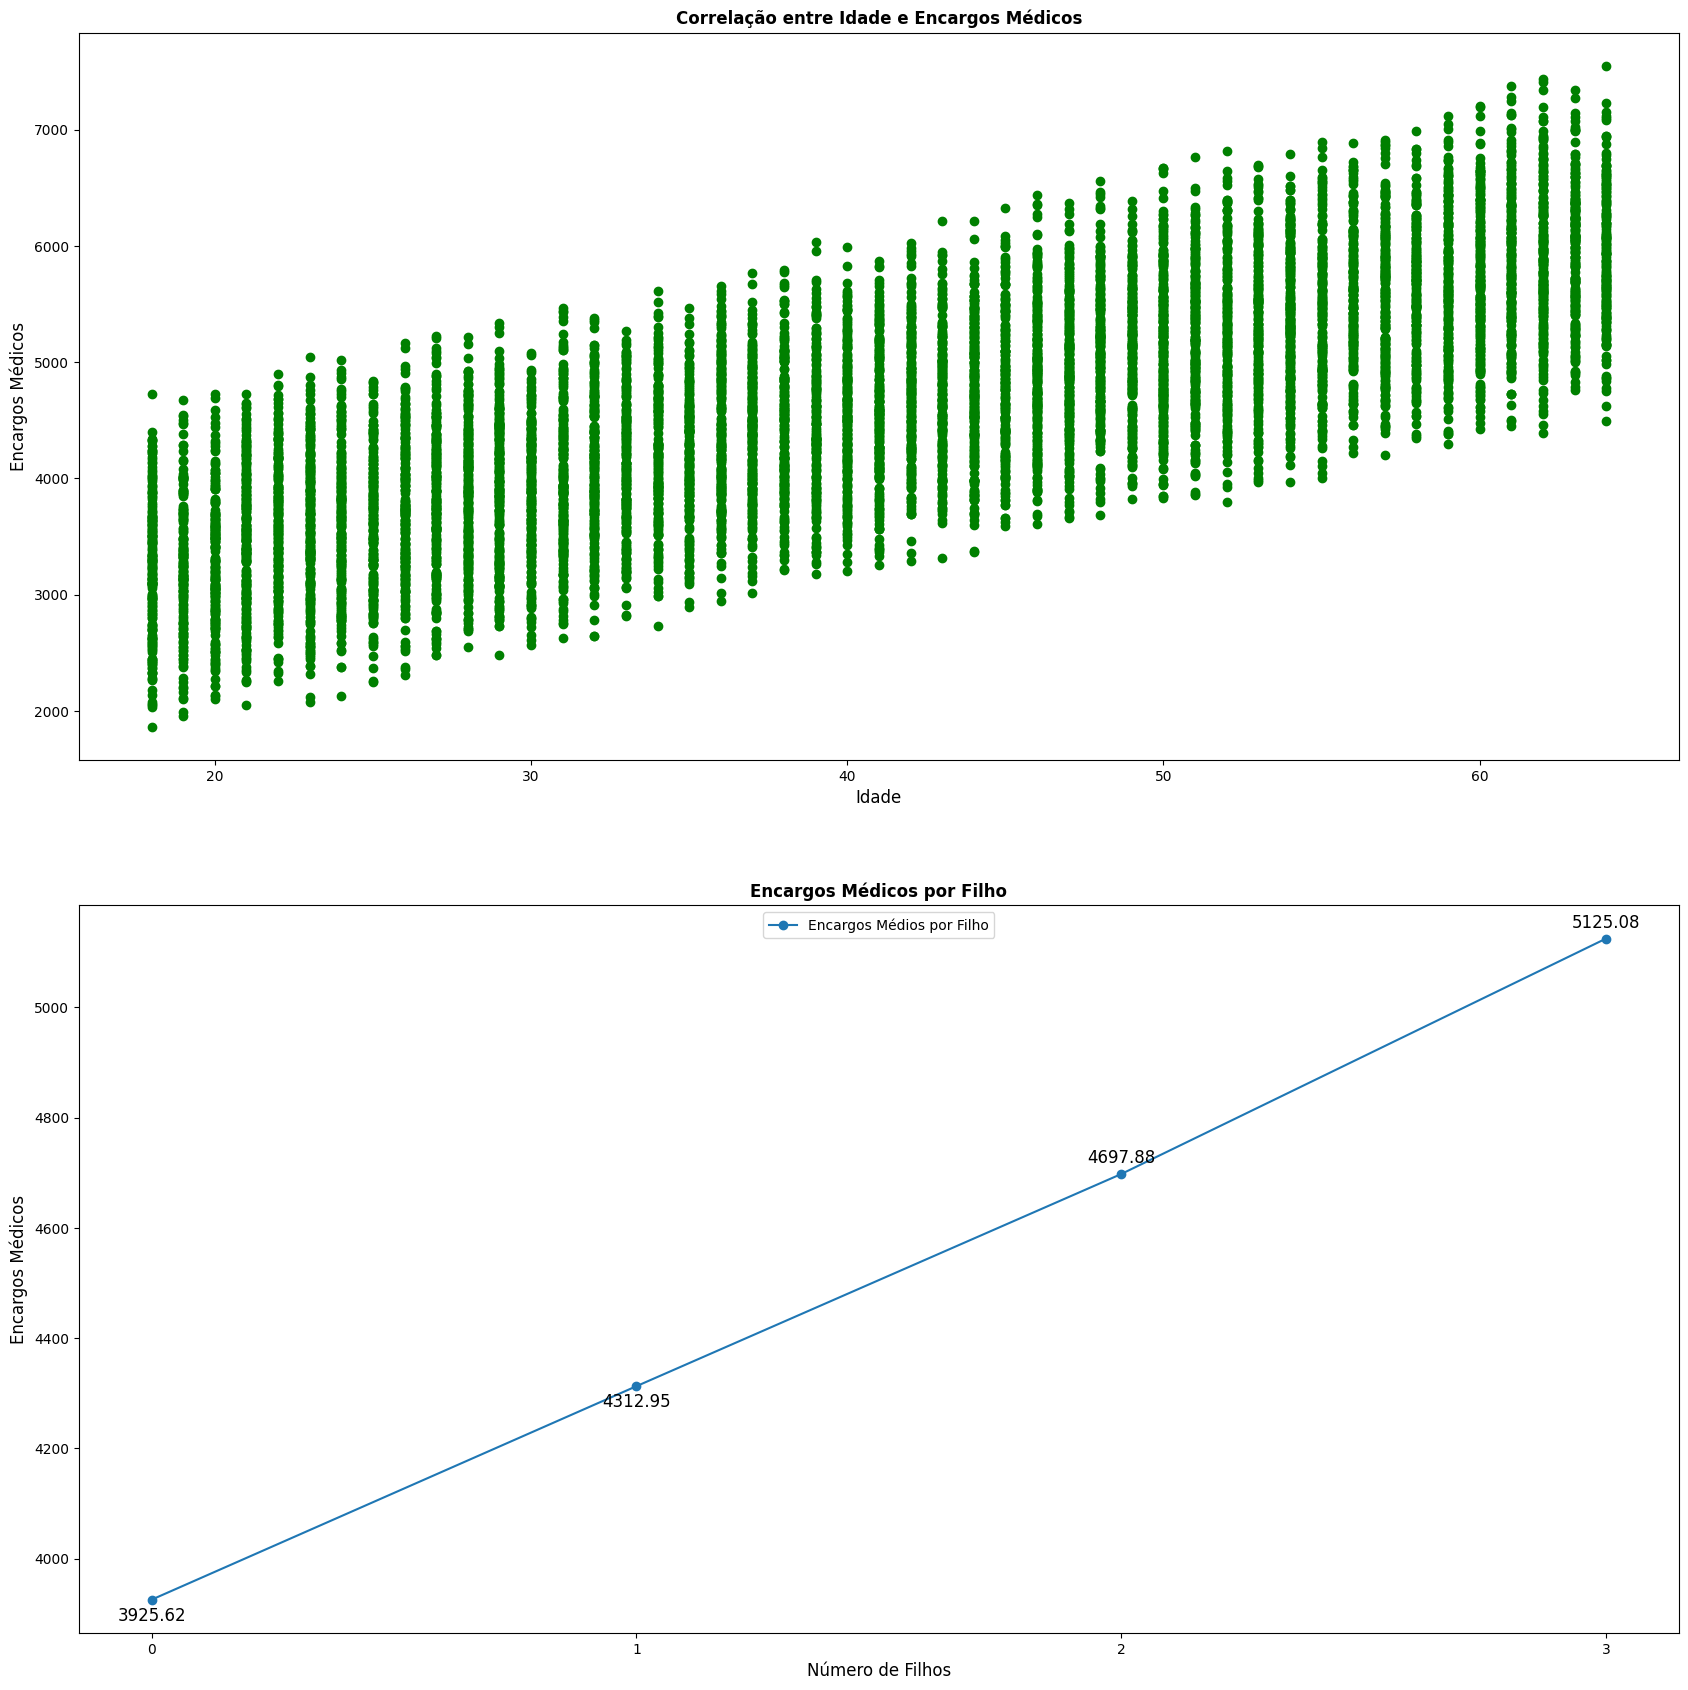

In [17]:
# Exibindo gráficos que demonstram a correlação entr features e o target (Encargos)
montar_graficos_relacionamento_encargos(dados)